# Theoretical Basis

## Audio Signal Processing

### STFT Spectrograms

In [1]:
import librosa as lr
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sr=22050
n_fft=2048
win_length=2048
window='hann'
hop_length=256

# https://freesound.org/people/xserra/sounds/196765/
piano, _ = lr.load('./Data/sounds/piano.wav', sr=sr)

# https://freesound.org/people/xserra/sounds/223370/
cello, _ = lr.load('./Data/sounds/cello-double.wav', sr=sr)

blues, _ = lr.load('./Data/gtzan/blues/blues.00001.au', sr=sr)
blues = blues[sr*1:sr*1+sr*7]

# https://freesound.org/people/xserra/sounds/205015/
ocean, _ = lr.load('./Data/sounds/ocean.wav', sr=sr)

In [5]:
ipd.Audio(data=piano, rate=sr)

In [6]:
ipd.Audio(data=cello, rate=sr)

In [7]:
ipd.Audio(data=blues, rate=sr)

In [8]:
ipd.Audio(data=ocean, rate=sr)

In [9]:
piano_spectrum = lr.stft(piano, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
cello_spectrum = lr.stft(cello, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
blues_spectrum = lr.stft(blues, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
ocean_spectrum = lr.stft(ocean, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)

#### stft_piano.png

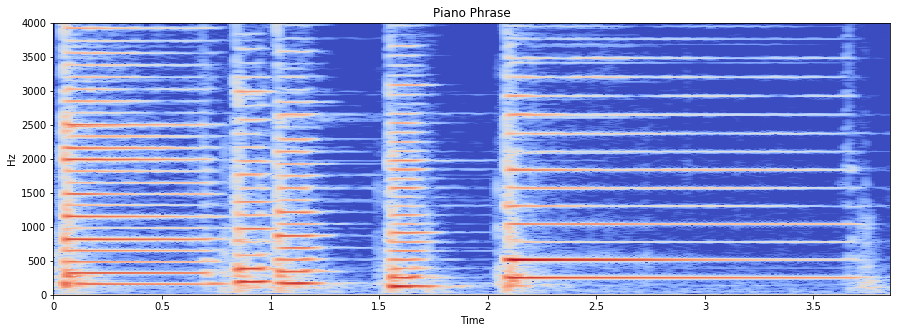

In [10]:
plt.figure(figsize=(15,5))
lr.display.specshow(data=lr.amplitude_to_db(abs(piano_spectrum)), x_axis='time', y_axis='linear', hop_length=hop_length, sr=sr)
plt.axis([0,piano_spectrum.shape[1]*hop_length*1/sr,0,4000])
plt.title("Piano Phrase")
plt.show()

#### stft_cello.png

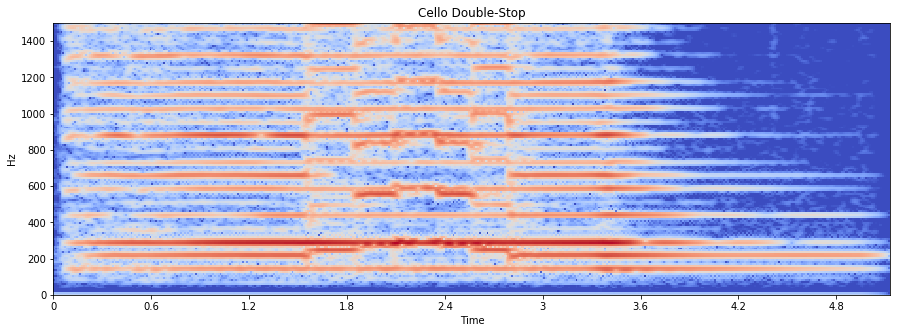

In [11]:
plt.figure(figsize=(15,5))
lr.display.specshow(data=lr.amplitude_to_db(abs(cello_spectrum)), x_axis='time', y_axis='linear', hop_length=hop_length, sr=sr)
plt.axis([0,cello_spectrum.shape[1]*hop_length*1/sr,0,1500])
plt.title("Cello Double-Stop")
plt.show()

#### stft_blues.png

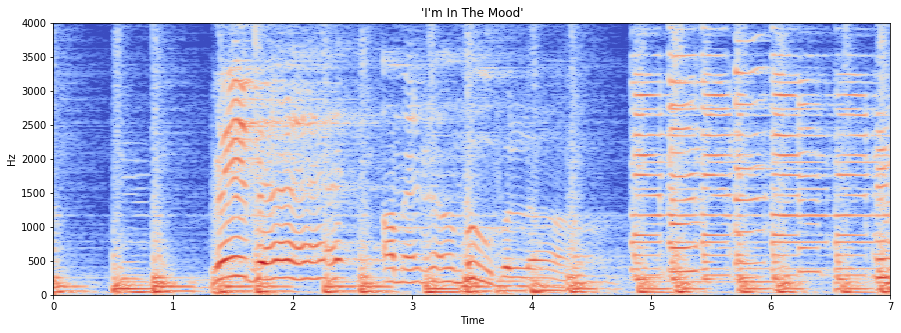

In [12]:
plt.figure(figsize=(15,5))
lr.display.specshow(data=lr.amplitude_to_db(abs(blues_spectrum)), x_axis='time', y_axis='linear', hop_length=hop_length, sr=sr)
plt.axis([0,blues_spectrum.shape[1]*hop_length*1/sr,0,4000])
plt.title("\'I\'m In The Mood'")
plt.show()

#### stft_ocean.png

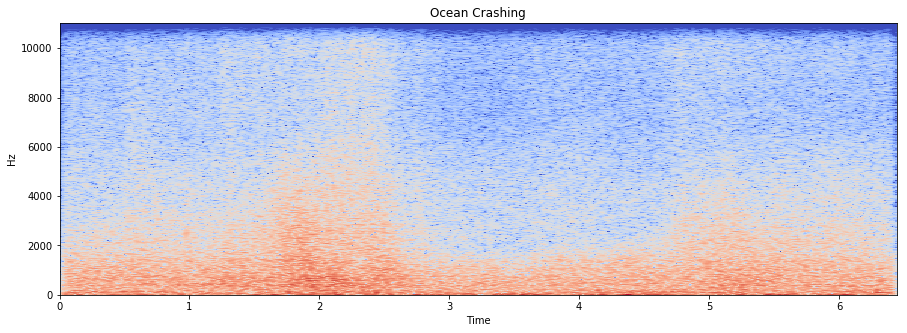

In [13]:
plt.figure(figsize=(15,5))
lr.display.specshow(data=lr.amplitude_to_db(abs(ocean_spectrum)), x_axis='time', y_axis='linear', hop_length=hop_length, sr=sr)
plt.title("Ocean Crashing")
plt.show()

# Methodology

## Datasets

### Free Music Archive

In [3]:
import numpy as np
import FMA
import keras

Using TensorFlow backend.


In [4]:
FMA = FMA.FreeMusicArchive('medium', 22050)
freq, time = 2049, 643

y_true = []
for i in FMA.PARTITION['test']:
    y_true.append(FMA.TOP_GENRES[i])

y_true = np.array(y_true)    
y_true_oh = keras.utils.to_categorical(y_true, num_classes=16)

labels = {}
for index, row in FMA.TRACKS.track.iterrows():
    labels[index] = FMA.CLASS_MAP[row['genre_top']]

In [5]:
FMA.TRACKS.track.genre_top.value_counts().sum(),\
FMA.TRACKS.track.loc[FMA.PARTITION['training']].genre_top.value_counts().sum(),\
FMA.TRACKS.track.loc[FMA.PARTITION['validation']].genre_top.value_counts().sum(),\
FMA.TRACKS.track.loc[FMA.PARTITION['test']].genre_top.value_counts().sum()

(24976, 19901, 2504, 2571)

In [6]:
FMA.TRACKS.track.loc[FMA.PARTITION['training']].genre_top.value_counts()

Rock                   5676
Electronic             5048
Experimental           1799
Hip-Hop                1752
Folk                   1214
Instrumental           1043
Pop                     945
International           814
Classical               495
Old-Time / Historic     408
Jazz                    306
Country                 142
Spoken                   94
Soul-RnB                 94
Blues                    58
Easy Listening           13
Name: genre_top, dtype: int64

In [7]:
FMA.TRACKS.track.loc[FMA.PARTITION['validation']].genre_top.value_counts()

Rock                   711
Electronic             631
Experimental           225
Hip-Hop                220
Folk                   152
Instrumental           131
Pop                    122
International          102
Classical               62
Old-Time / Historic     51
Jazz                    39
Soul-RnB                18
Country                 18
Spoken                  12
Blues                    8
Easy Listening           2
Name: genre_top, dtype: int64

In [8]:
FMA.TRACKS.track.loc[FMA.PARTITION['test']].genre_top.value_counts()

Rock                   710
Electronic             632
Experimental           224
Hip-Hop                220
Instrumental           174
Folk                   152
Pop                    119
International          102
Classical               62
Old-Time / Historic     51
Soul-RnB                42
Jazz                    39
Country                 18
Spoken                  12
Blues                    8
Easy Listening           6
Name: genre_top, dtype: int64

## Feature Selection

### STFT Parameters

In [1]:
import librosa as lr

In [2]:
sr=22050
n_fft=4096
win_length=4096
window='hann'
hop_length=1024

In [3]:
blues, _ = lr.load('./Data/gtzan/blues/blues.00001.au', sr=sr)

In [4]:
blues.size, blues.size/sr

(661794, 30.013333333333332)

In [5]:
blues_spectrum = lr.stft(blues, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
blues_spectrum.shape

(2049, 647)

In [6]:
print(f'Hop Length {1000*hop_length*1/sr:.2f} ms')

Hop Length 46.44 ms


In [7]:
print(f'Window Length {1000*win_length*1/sr:.2f} ms')

Window Length 185.76 ms


In [8]:
(blues.size/sr) / (1024*1/sr)

646.283203125

## Convolutional Neural Network Architectures

### Time/Frequency Favoring Hypothesis

In [15]:
import librosa as lr
import librosa.display
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Conv2D

In [11]:
sr=22050
n_fft=4096
win_length=2048
window='hann'
hop_length=512

y, _ = lr.load('./Data/sounds/piano.wav', sr=sr)
spectrum = abs(lr.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window))

In [12]:
def get_conv(x, w, kernel_size, strides, ih, iw):
    
    model = Sequential()
    model.add(Conv2D(1, kernel_size=kernel_size, strides=strides, input_shape=(ih, iw, 1), padding='SAME', use_bias=False, name='conv'))
    model.set_weights(w)
    
    out_h = model.get_layer('conv').output_shape[1]
    out_w = model.get_layer('conv').output_shape[2]

    model.add(Activation('relu'))
    
    print(model.summary())
    
    y = x.reshape(1, ih, iw, 1)
    
    spec = model.predict(y)
    
    return spec.reshape(out_h, out_w)

In [16]:
inh, inw, = spectrum.shape[0], spectrum.shape[1]

kernel_size = (3, 3)
strides = (1, 1)

w = [np.array([ -1,-1, -1,
                -1, 8, -1,
                -1,-1, -1]).reshape(3, 3, 1, 1)]
      
ed3x3 = get_conv(spectrum, w, kernel_size, strides, inh, inw)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 2049, 166, 1)      9         
_________________________________________________________________
activation_1 (Activation)    (None, 2049, 166, 1)      0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
kernel_size = (9, 1)
strides = (1, 1)

w = [np.array([-1,
               -1,
               -1,
               -1,
                8,
               -1,
               -1,
               -1,
               -1]).reshape(9, 1, 1, 1)]

ed9x1 = get_conv(spectrum, w, kernel_size, strides, inh, inw)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 2049, 166, 1)      9         
_________________________________________________________________
activation_2 (Activation)    (None, 2049, 166, 1)      0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
kernel_size = (1, 9)
strides = (1, 1)

w = [np.array([-1, -1, -1, -1, 8, -1, -1, -1, -1]).reshape(1, 9, 1, 1)]

ed1x9 = get_conv(spectrum, w, kernel_size, strides, inh, inw)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 2049, 166, 1)      9         
_________________________________________________________________
activation_3 (Activation)    (None, 2049, 166, 1)      0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


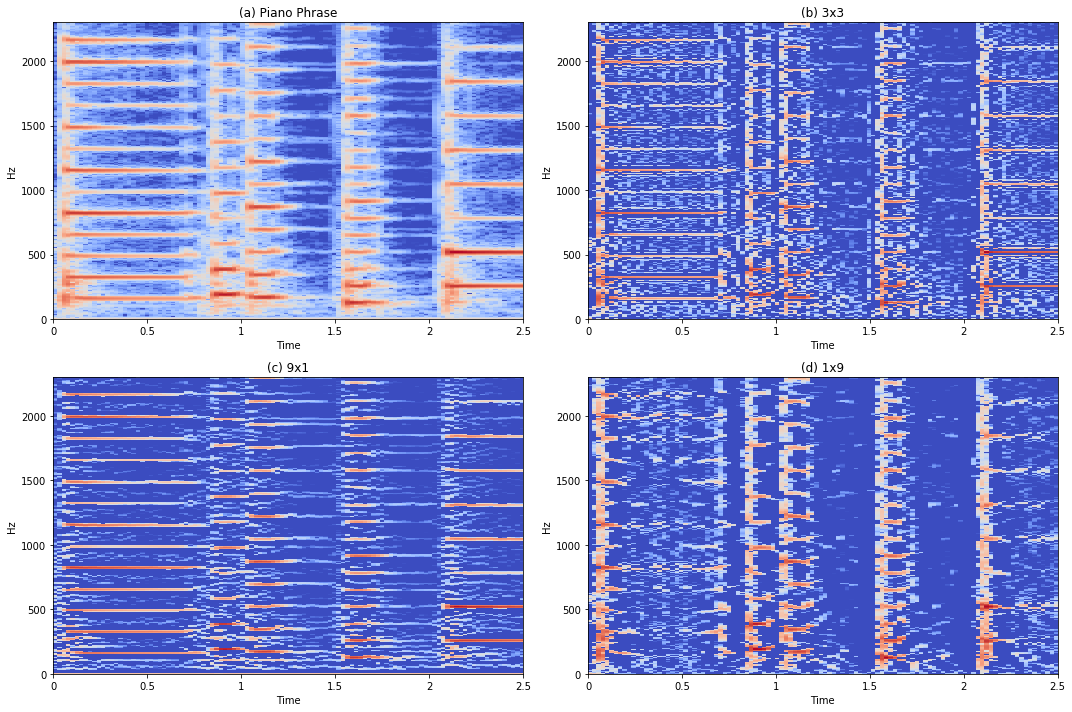

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(221)
librosa.display.specshow(
    data=lr.amplitude_to_db(spectrum),
    x_axis='time',
    y_axis='linear',
    sr=sr,
    hop_length=hop_length 
)
plt.axis([0, 2.5, 0, 2300])
plt.title("(a) Piano Phrase")

plt.subplot(222)
librosa.display.specshow(
    data=lr.amplitude_to_db(ed3x3),
    x_axis='time',
    y_axis='linear',
    sr=sr,
    hop_length=hop_length 
)
plt.axis([0, 2.5, 0, 2300])
plt.title("(b) 3x3")

plt.subplot(223)
librosa.display.specshow(
    data=lr.amplitude_to_db(ed9x1),
    x_axis='time',
    y_axis='linear',
    sr=sr,
    hop_length=hop_length 
)
plt.axis([0, 2.5, 0, 2300])
plt.title("(c) 9x1")

plt.subplot(224)
librosa.display.specshow(
    data=lr.amplitude_to_db(ed1x9),
    x_axis='time',
    y_axis='linear',
    sr=sr,
    hop_length=hop_length 
)
plt.axis([0, 2.5, 0, 2300])
plt.title("(d) 1x9")
plt.tight_layout()
plt.show()

# Results

In [1]:
import numpy as np
import scipy
import sklearn
from sklearn import metrics
import pandas as pd

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import FMA

## FMA Medium Single Genre Classification

In [2]:
FMA = FMA.FreeMusicArchive('medium', 22050)
freq, time = 2049, 643

y_true = []
for i in FMA.PARTITION['test']:
    y_true.append(FMA.TOP_GENRES[i])

y_true = np.array(y_true)    

labels = {}
for index, row in FMA.TRACKS.track.iterrows():
    labels[index] = FMA.CLASS_MAP[row['genre_top']]

### STFT Halved

In [3]:
res=pd.read_pickle('./Results/fma_med.stft_halved.pkl')
res.columns

Index(['name', 'hist_acc', 'hist_val_acc', 'accuracy', 'f1_macro', 'f1_micro',
       'f1_weighted', 'softmax_out', 'epochs'],
      dtype='object')

In [5]:
res.sort_values(by='f1_micro', ascending=False).loc[:,['name', 'f1_micro', 'epochs']]

,name,f1_micro,epochs
3,TimeFreq,0.630494,11
0,Time,0.597822,17
2,Simple,0.595488,17
1,Freq,0.582264,21


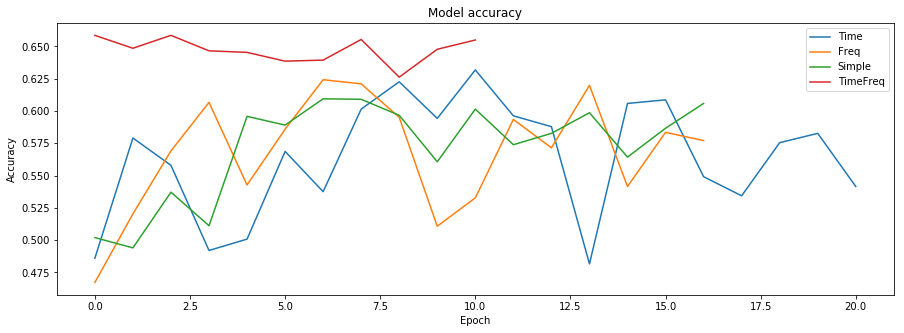

In [6]:
hist_freq = res.loc[2]['hist_val_acc']
hist_time = res.loc[1]['hist_val_acc']
hist_simple = res.loc[0]['hist_val_acc']
hist_tf = res.loc[3]['hist_val_acc']

plt.figure(figsize=(15,5))
plt.plot(hist_time)
plt.plot(hist_freq)
plt.plot(hist_simple)
plt.plot(hist_tf)

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Time', 'Freq', 'Simple', 'TimeFreq'], loc='best')
plt.show()

In [14]:
res.softmax_out[0].argmax(1)

array([13, 13,  5, ...,  4,  4,  4], dtype=int64)

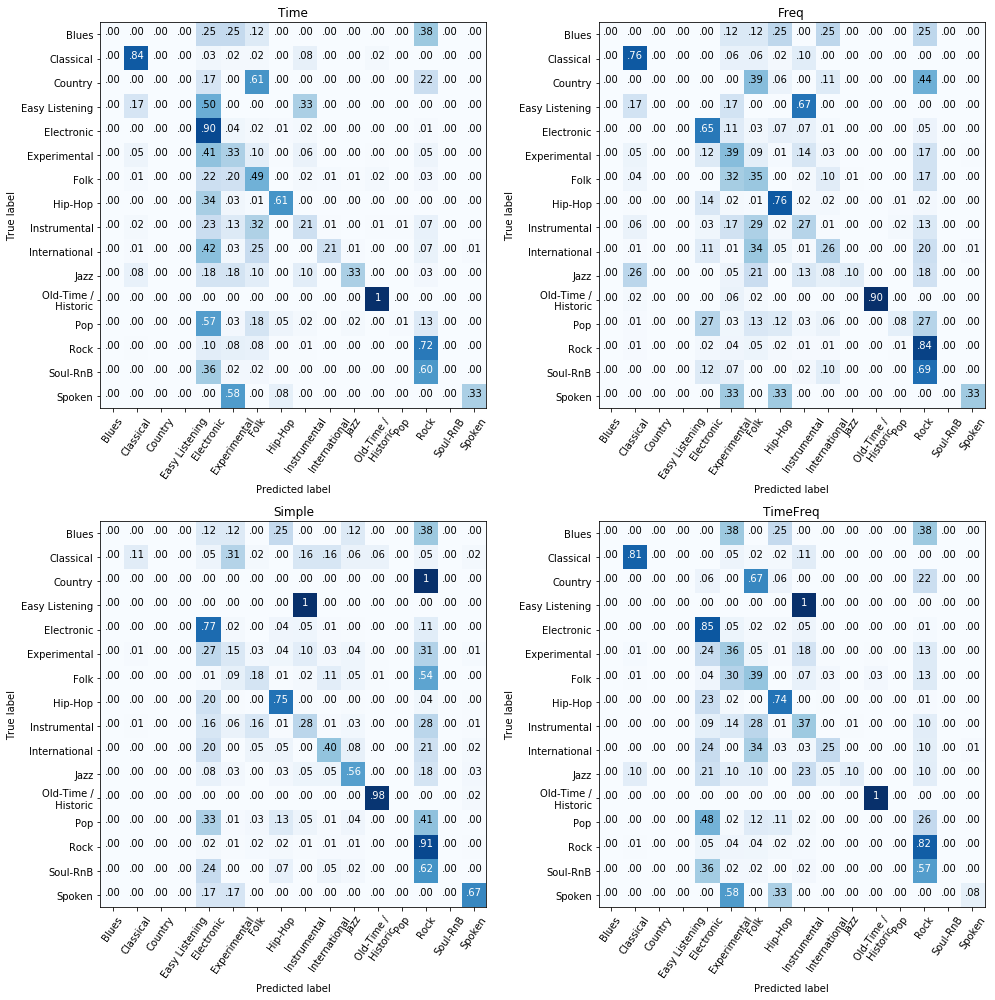

In [17]:
class_map = ['Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time /\n Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken']

def convert_labels(y, class_map):
    inv_map = {v: k for k, v in class_map.items()}
    labels = []
    for x in y:
        labels.append(inv_map[x])
    
    return np.array(labels)

cms = {}
plt.figure(figsize=(14,14))
for i, row in res.iterrows():
    normalize = True
    
    pred = convert_labels(row['softmax_out'].argmax(1), FMA.CLASS_MAP)
    y = convert_labels(y_true, FMA.CLASS_MAP)
    
    cm = metrics.confusion_matrix(y, pred, labels=list(FMA.CLASS_MAP.keys()))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    cms[row['name']] = cm
    
    
    plt.subplot(2,2,i+1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(row['name'])
    tick_marks = np.arange(len(class_map))
    plt.xticks(tick_marks, class_map, rotation=55)
    plt.yticks(tick_marks, class_map)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] == 1:
            plt.text(j, i, format(1, 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt)[1:],
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.tight_layout()
plt.show()

In [18]:
cms['TimeFreq']

FP = cms['TimeFreq'].sum(axis=0) - np.diag(cms['TimeFreq'])  
FN = cms['TimeFreq'].sum(axis=1) - np.diag(cms['TimeFreq'])
TP = np.diag(cms['TimeFreq'])

sTP = sum(TP)
sFN = sum(FN)
sFP = sum(FP)

# Sensitivity, hit rate, recall, or true positive rate
rec = TP/(TP+FN)
mrec = sTP/(sTP+sFN)

# Precision or positive predictive value
prec = TP/(TP+FP)
mprec = sTP/(sTP+sFP)

# F1
F1 = np.nan_to_num(2*(prec*rec)/(prec+rec))
mF1 = np.nan_to_num(2*(mprec*mrec)/(mprec+mrec))

FP, FN, TP, F1, np.mean(F1), mF1

c:\users\ryanw\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


(array([0.        , 0.12816971, 0.        , 0.        , 1.98540532,
        1.70029702, 1.65898522, 0.84828936, 1.73523047, 0.08959831,
        0.00574713, 0.03078008, 0.        , 2.01758124, 0.        ,
        0.01121237]),
 array([1.        , 0.19354839, 1.        , 1.        , 0.15189873,
        0.63839286, 0.60526316, 0.25909091, 0.62643678, 0.74509804,
        0.8974359 , 0.        , 1.        , 0.17746479, 1.        ,
        0.91666667]),
 array([0.        , 0.80645161, 0.        , 0.        , 0.84810127,
        0.36160714, 0.39473684, 0.74090909, 0.37356322, 0.25490196,
        0.1025641 , 1.        , 0.        , 0.82253521, 0.        ,
        0.08333333]),
 array([0.        , 0.83370487, 0.        , 0.        , 0.44246762,
        0.23619756, 0.25852834, 0.57230769, 0.2403268 , 0.37917725,
        0.18508177, 0.98484323, 0.        , 0.42839076, 0.        ,
        0.15227018]),
 0.29458100423483174,
 0.3617939863086042)

In [20]:
ml = []
name = []
for i, row in res.iterrows():
    name.append(row['name'])
    ml.append(metrics.classification_report(
        y_true, row['softmax_out'].argmax(1), target_names=FMA.CLASS_MAP.keys(), output_dict=True
    ))

dfb = pd.DataFrame(data={'label':list(FMA.CLASS_MAP.keys())})

for name, data in zip(name, ml):
    dfb[name] = [
        data['Blues']['f1-score'],
        data['Classical']['f1-score'],
        data['Country']['f1-score'],
        data['Easy Listening']['f1-score'],
        data['Electronic']['f1-score'],
        data['Experimental']['f1-score'],
        data['Folk']['f1-score'],
        data['Hip-Hop']['f1-score'],
        data['Instrumental']['f1-score'],
        data['International']['f1-score'],
        data['Jazz']['f1-score'],
        data['Old-Time / Historic']['f1-score'],
        data['Pop']['f1-score'],
        data['Rock']['f1-score'],
        data['Soul-RnB']['f1-score'],
        data['Spoken']['f1-score'],
    ]

c:\users\ryanw\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
dfb

,label,Time,Freq,Simple,TimeFreq
0,Blues,0.000000,0.000000,0.000000,0.000000
1,Classical,0.742857,0.591195,0.194444,0.806452
2,Country,0.000000,0.000000,0.000000,0.000000
3,Easy Listening,0.000000,0.000000,0.000000,0.000000
4,Electronic,0.687198,0.701454,0.723088,0.745999
5,Experimental,0.313978,0.340509,0.204969,0.352174
6,Folk,0.337900,0.261728,0.230769,0.318302
7,Hip-Hop,0.727763,0.697286,0.708423,0.745995
8,Instrumental,0.282353,0.283988,0.319218,0.359116
9,International,0.328125,0.288770,0.420513,0.376812


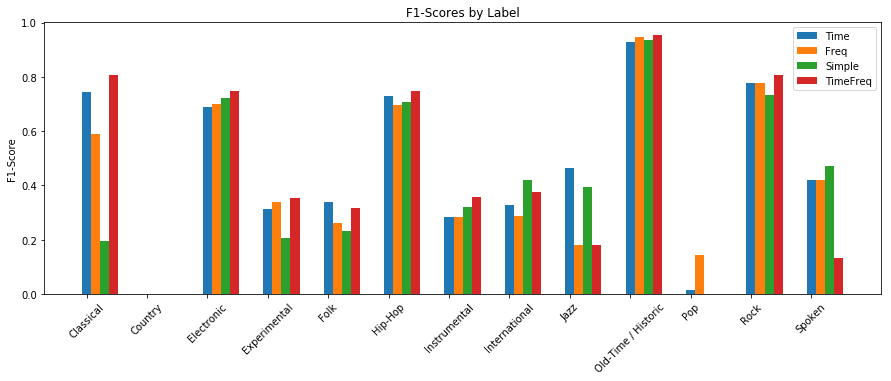

In [22]:
dfb2 = dfb.loc[[1,2,4,5,6,7,8,9,10,11,12,13,15]]

N = len(dfb2)
time = dfb2.Time
freq = dfb2.Freq
simple = dfb2.Simple
tf = dfb2.TimeFreq

ind = np.arange(N) 
width = 0.15       

plt.figure(figsize=(15,5))
plt.bar(ind, time, width, label='Time')
plt.bar(ind + width, freq, width, label='Freq')
plt.bar(ind + width*2, simple, width, label='Simple')
plt.bar(ind + width*3, tf, width, label='TimeFreq')

plt.ylabel('F1-Score')
plt.title('F1-Scores by Label')

tick_marks = np.arange(len(dfb2.label.values))
plt.xticks(tick_marks, dfb2.label.values, rotation=45)
plt.legend(loc='best')
plt.show()

# Appendix

## Models

### Medium Genre Classification

##### STFT

In [1]:
from keras.utils import plot_model
from keras.utils.vis_utils  import model_to_dot
from keras.models import load_model

Using TensorFlow backend.


In [2]:
time_stft = load_model("./Models/fma_med.stft.Time.hdf5")
freq_stft = load_model("./Models/fma_med.stft.Freq.hdf5")
simple_stft = load_model("./Models/fma_med.stft.Simple.hdf5")
tf_stft = load_model("./Models/fma_med.stft.TimeFreq.hdf5")

In [3]:
print(time_stft.summary())
print(freq_stft.summary())
print(simple_stft.summary())
print(tf_stft.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2049, 643, 1) 0                                            
__________________________________________________________________________________________________
input_over_4 (Conv2D)           (None, 2049, 322, 2) 320         input_1[0][0]                    
__________________________________________________________________________________________________
input_over_8 (Conv2D)           (None, 2049, 322, 2) 160         input_1[0][0]                    
__________________________________________________________________________________________________
input_over_16 (Conv2D)          (None, 2049, 322, 2) 80          input_1[0][0]                    
__________________________________________________________________________________________________
input_over

In [12]:
plot_model(
    time_stft, 
    show_shapes=True, 
    show_layer_names=False, 
    to_file='E:\\OneDrive\\Regis\\Thesis\\HAAMR\\Thesis\\figures\\time_stft_model.png'
)
plot_model(
    freq_stft, 
    show_shapes=True, 
    show_layer_names=False, 
    to_file='E:\\OneDrive\\Regis\\Thesis\\HAAMR\\Thesis\\figures\\freq_stft_model.png'
)
plot_model(
    simple_stft, 
    show_shapes=True, 
    show_layer_names=False, 
    to_file='E:\\OneDrive\\Regis\\Thesis\\HAAMR\\Thesis\\figures\\simple_stft_model.png'
)
plot_model(
    tf_stft, 
    show_shapes=True, 
    show_layer_names=False, 
    to_file='E:\\OneDrive\\Regis\\Thesis\\HAAMR\\Thesis\\figures\\tf_stft_model.png'
)